In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import sklearn
import seaborn as sns
import mlflow 
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix 

print(f"numpy version {np.__version__}")
print(f"pandas version {pd.__version__}")
print(f"matplotlib version {mpl.__version__}")
print(f"seaborn version {sns.__version__}")
print(f"sklearn version {sklearn.__version__}")
print(f"MLFlow version {mlflow.__version__}")

numpy version 1.23.1
pandas version 1.4.3
matplotlib version 3.5.2
seaborn version 0.11.2
sklearn version 1.1.1
MLFlow version 1.27.0


## 데이터 불러오기

In [2]:
import os

# print(os.getcwd())
DATA_PATH = 'C:\\Users\\human\\Desktop\\mlops_sam\\data\\sales_forecast\\'

train_df = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
submission = pd.read_csv(DATA_PATH + 'gender_submission.csv')

train_df.shape, test.shape, submission.shape

((891, 12), (418, 11), (418, 2))

- 데이터 탐색

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Age, Cabin, Embarked에 대해 결측치 존재

## 데이터 시각화
- 종속변수 : Survived
- 숫자 1 -> 생존 / 숫자 0 -> 사망

In [4]:
survived = train_df[train_df['Survived'] == 1]
deceased = train_df[train_df['Survived'] == 0]

print(f'Survived : {survived.shape}')
print(f'Deceased : {deceased.shape}')

Survived : (342, 12)
Deceased : (549, 12)


- seaborn
- matplotlib

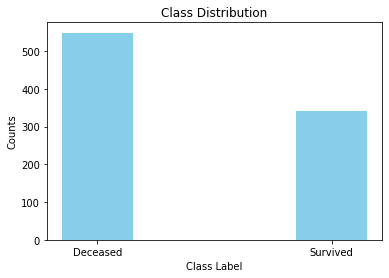

In [37]:
class_df = train_df['Survived'].value_counts(sort = True)
class_df

fig, ax = plt.subplots()
ax.bar(class_df.index, class_df.values, color = 'skyblue', width = 0.3)
ax.set_xticks(range(2), ['Deceased', 'Survived'])
ax.set_title('Class Distribution')
ax.set_xlabel('Class Label')
ax.set_ylabel('Counts')
       
plt.show()

- 연령별 분포 확인
- 연령별로 확인 구분이 잘 안됨

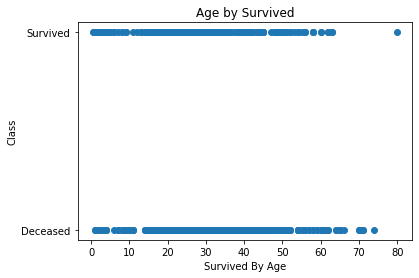

In [6]:
fig, ax = plt.subplots()
ax.scatter(train_df['Age'], train_df['Survived'])
ax.set_title("Age by Survived")
ax.set_ylabel("Class")
ax.set_yticks(range(2), ["Deceased", "Survived"])
ax.set_xlabel("Survived By Age")
plt.show()

- 사용자 정의 함수를 만들어서 활용
- countplot() 함수 활용

In [7]:
def plot_bar(data, column = None):
    if column is not None:
        # 시각화 코드 작성
        fig, ax = plt.subplots(1, 2, figsize = (18, 8))
        data[[column, 'Survived']].groupby([column]).mean().plot.bar(ax=ax[0])
        sns.countplot(x = column, hue = 'Survived', data = data, ax=ax[1])
        ax[1].legend(labels = ['Dead', 'Survived'])
        ax[1].set_title(f'{column} : Survived vs Dead')
    else:
        print('Please Enter Column')
    
    # return None

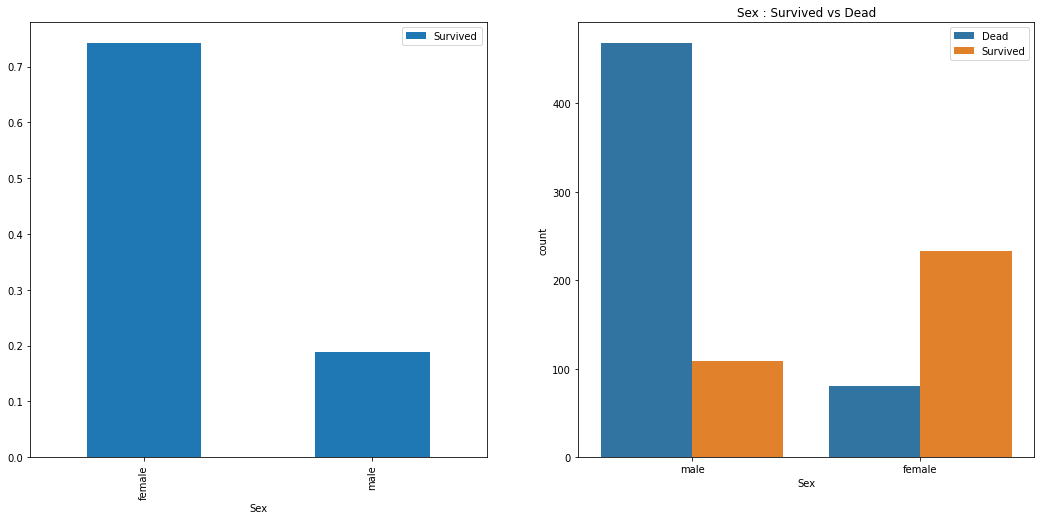

In [8]:
column = 'Sex'
plot_bar(train_df, column)

- 여성이 남성보다 상대적으로 더 많이 생존했음

- Pclass 별 생존 유무 막대 그래프를 그려본다
- 1번 클래스에 속할수록 생존 확률 높음

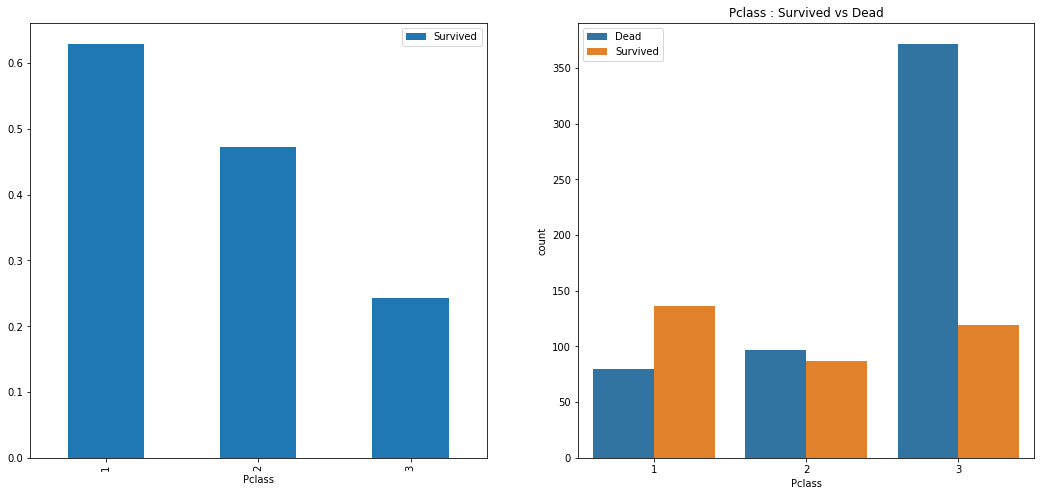

In [9]:
column = 'Pclass'
plot_bar(train_df, column)

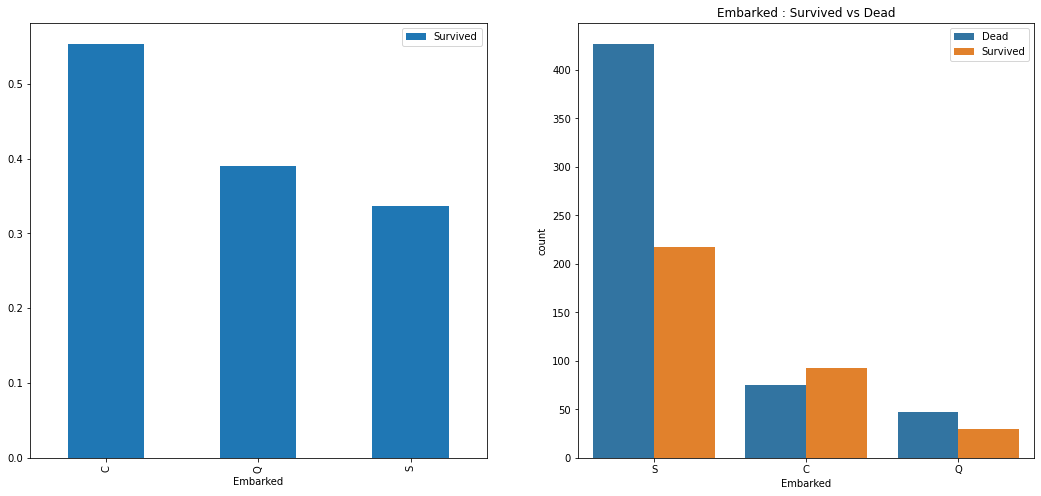

In [10]:
column = 'Embarked'
plot_bar(train_df, column)

## 결측치 대치
- 컬럼 3개
- How to deal with missing columns?
    - Cabin 삭제
    - Embarked 2개 뿐, 최빈도로 채우기
    - Age 177개
        - 그룹으로 대치

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Name 피처 확인

In [12]:
train_df['Name'][:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- 호칭의 패턴을 보고 데이터 추출
- 키워드 : 정규표현식

In [13]:
train_df['Initial'] = 0
for _ in [train_df, test]:
    train_df['Initial'] = train_df['Name'].str.extract('([A-Za-z]+)\.') # 
    test['Initial'] = test['Name'].str.extract('([A-Za-z]+)\.') # 

In [14]:
train_df[['Name', 'Initial']].head()

,Name,Initial
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [15]:
pd.crosstab(train_df['Initial'], train_df['Sex']).T

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [16]:
pd.crosstab(test['Initial'], test['Sex']).T

Initial,Col,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
Sex,,,,,,,,,
female,0,1,0,0,78,0,72,1,0
male,2,0,1,21,0,240,0,0,2


- 미성년자, Miss, Mr, Mrs, Other

In [17]:
b4_title    = ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona']
after_title = ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Miss']

train_df['Initial'] = train_df['Initial'].replace(b4_title, after_title)
train_df.shape

(891, 13)

In [18]:
test['Initial'] = test['Initial'].replace(b4_title, after_title)
test.shape

(418, 12)

- Initial을 그룹으로 평균연령을 구할 수 있음

In [19]:
train_df.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [20]:
# train_df.loc[조건식, 'Age'] = 33.
train_df.loc[(train_df['Age'].isnull())&(train_df['Initial']=='Mr'),'Age']=33
train_df.loc[(train_df['Age'].isnull())&(train_df['Initial']=='Mrs'),'Age']=36
train_df.loc[(train_df['Age'].isnull())&(train_df['Initial']=='Master'),'Age']=5
train_df.loc[(train_df['Age'].isnull())&(train_df['Initial']=='Miss'),'Age']=22
train_df.loc[(train_df['Age'].isnull())&(train_df['Initial']=='Other'),'Age']=46

In [21]:
test.loc[(test['Age'].isnull())&(test['Initial']=='Mr'),'Age']=33
test.loc[(test['Age'].isnull())&(test['Initial']=='Mrs'),'Age']=39
test.loc[(test['Age'].isnull())&(test['Initial']=='Master'),'Age']=8
test.loc[(test['Age'].isnull())&(test['Initial']=='Miss'),'Age']=22
test.loc[(test['Age'].isnull())&(test['Initial']=='Other'),'Age']=43

# Fare Mean
test['Fare'] = test['Fare'].fillna(np.mean(test['Fare']))

In [22]:
train_df['Embarked'].fillna('S', inplace = True)
# train_df['Embarked'] = train_df['Embarked'].fillna('S')
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Initial          0
dtype: int64

In [23]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Initial          0
dtype: int64

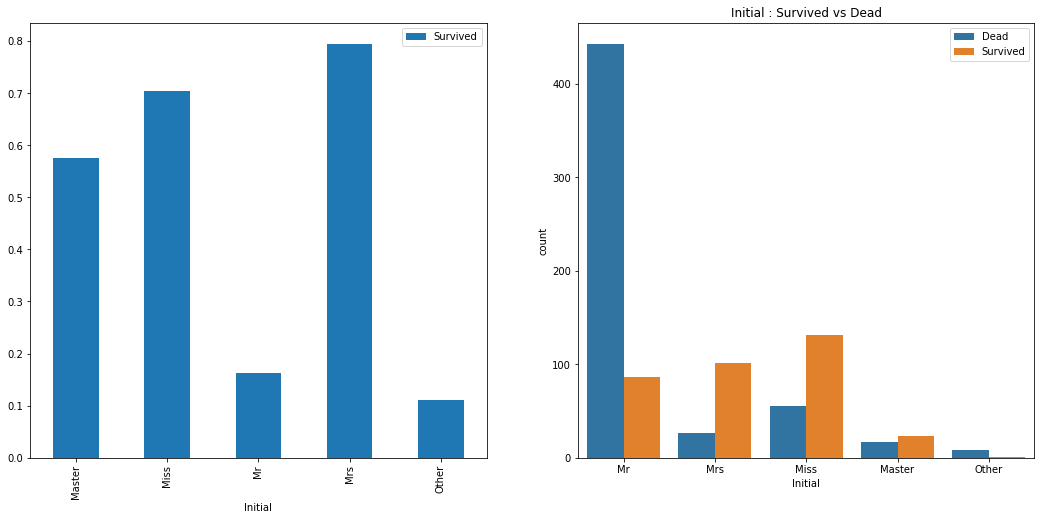

In [24]:
column = 'Initial'
plot_bar(train_df, column)

## Feature 제거
- 불필요한 컬럼 제거
    + name 피처 제거
    + Ticket 피처 제거 (무작위 문자형)
    + Cabin은 결측치가 매우 많음
    + PassengerId 제거

In [25]:
train_df.shape, test.shape

((891, 13), (418, 12))

In [26]:
cols = ['Name', 'Ticket', 'Cabin', 'PassengerId']
train_df = train_df.drop(cols, axis = 1)
test = test.drop(cols, axis = 1)

train_df.shape, test.shape

((891, 9), (418, 8))

## 인코딩 변환
- Ordinal Encoding, Label Encoding, One-Hot Encoding

In [27]:
train_df = pd.get_dummies(train_df)
test = pd.get_dummies(test)

train_df.shape, test.shape

((891, 16), (418, 15))

## 데이터셋 분리
- 분류 학습 진행 시, 불균형 데이터셋을 분리할때 종종 쓰는 코드

In [28]:
deceased = train_df[train_df['Survived'] == 0].sample(frac=0.5, random_state=42).reset_index(drop=True)
survived = train_df[train_df['Survived'] == 1]

deceased_train, deceased_test = train_test_split(deceased, test_size = 0.2, random_state=42)
survived_train, survived_test = train_test_split(survived, test_size = 0.2, random_state=42)

deceased_train, deceased_validate = train_test_split(deceased_train, test_size = 0.25, random_state=42)
survived_train, survived_validate = train_test_split(survived_train, test_size = 0.25, random_state=42)

deceased_train.shape, deceased_validate.shape, survived_train.shape, survived_validate.shape 

((164, 16), (55, 16), (204, 16), (69, 16))

In [29]:
X_train = pd.concat((deceased_train, survived_train))
X_test = pd.concat((deceased_test, survived_test))
X_validate = pd.concat((deceased_validate, survived_validate))

y_train = np.array(X_train["Survived"])
y_test = np.array(X_test["Survived"])
y_validate = np.array(X_validate["Survived"])

X_train = X_train.drop("Survived", axis = 1)
X_test = X_test.drop("Survived", axis = 1)
X_validate = X_validate.drop("Survived", axis = 1)

X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((368, 15), (124, 15), (124, 15), (368,), (124,), (124,))

## MLFlow 학습 및 평가
- 모델 만들고 예측하고, 제출하면 끝

In [30]:
def train(ml_model, X_train, y_train):
    ml_model = ml_model.fit(X_train, y_train)
    train_acc = ml_model.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: (train_acc:.3%)")
    

def evaluate(ml_model, X_test, y_test):
    eval_acc = ml_model.score(X_test, y_test)
    preds = ml_model.predict(X_test)
    auc_score = roc_auc_score(y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    
    print(f"Auc Score : {auc_score:.3%}")
    print(f"Eval Score : {eval_acc:.3%}")
    roc_plot = plot_roc_curve(ml_model, X_test, y_test, name="Scikit-Learn ROC Curve")
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

- 테스트

Train Accuracy: (train_acc:.3%)
Auc Score : 78.748%
Eval Score : 79.839%


C:\Users\human\Desktop\mlops_sam\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


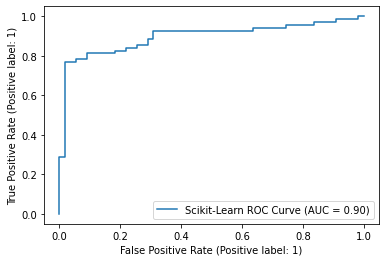

Model run:  1744fb66eff44f728210ce2e1cc88a78


C:\Users\human\Desktop\mlops_sam\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


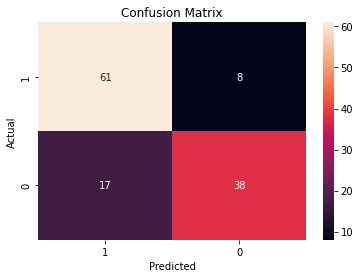

In [31]:
# 모델 설정
ml_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg')

# 실험 이름 설정
mlflow.set_experiment("human_sklearn_experiment")

# 해당 이름으로 실행 배치
with mlflow.start_run():
    train(ml_model, X_train, y_train)
    evaluate(ml_model, X_test, y_test)
    
    # 하나의 MLFlow 실행 컨텍스트에서 모든 코드를 묶을 수 있음. 
    # 참조 : https://mlflow.org/docs/latest/models.html#model-customization
    mlflow.sklearn.log_model(ml_model, 'log_reg_model')
    
    # 본질적으로 모델과 지표가 로깅되는 현재 실행을 가져오고 출력함. 
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [33]:
logged_model = 'runs:/e65c76e89e194341b979b77a533d2ef5/log_reg_model'
loaded_model = mlflow.pyfunc.load_model(logged_model)

final_preds = loaded_model.predict(test)
submission['Survived']=final_preds
submission.to_csv(DATA_PATH + "submission.csv", index=False)